*This post was entirely written using the IPython notebook. Its content is BSD-licensed. You can see a static view or download this notebook with the help of nbviewer at [20160901_RemovingBackgroundFromImage.ipynb](http://nbviewer.ipython.org/urls/raw.github.com/flothesof/posts/master/20160901_RemovingBackgroundFromImage.ipynb).*

In this notebook, we're going to discuss a problem that can be encountered with images: removing the background of an image. Our study will focus on the image presented in [this stackoverflow question](http://stackoverflow.com/questions/29313667/how-do-i-remove-the-background-from-this-kind-of-image). We'll use scikit-image to remove the background of the following image:

![http://i.stack.imgur.com/SYxmp.jpg](http://i.stack.imgur.com/SYxmp.jpg)

# Loading the image 

Let's get started. We first load the image, using the `imread` routine from scikit-image. 

In [1]:
from skimage import io as skio
url = 'http://i.stack.imgur.com/SYxmp.jpg'
img = skio.imread(url)

What sort of image do we get?

In [2]:
print("shape of image: {}".format(img.shape))
print("dtype of image: {}".format(img.dtype))

shape of image: (1100, 762)
dtype of image: uint8


This is actually a gray image. We will remove the background using the following approach: 

- detect edges
- seed the obtained image to separate background from foreground
- perform a watershed transformation

# Detecting the edges 

To detect the edges, we use the sobel filter:

In [3]:
from skimage import filters
sobel = filters.sobel(img)

Let's display this:

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['figure.dpi'] = 200

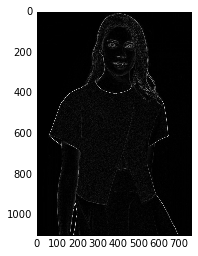

In [5]:
plt.imshow(sobel)

Let's now blur this image a bit to make the edges thicker:

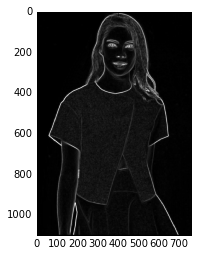

In [6]:
blurred = filters.gaussian(sobel, sigma=2.0)
plt.imshow(blurred)

# Obtaining seeds for the watershed transform 

To perform a watershed transform on this image, we need to assign classes to the fore and background. There's two ways that I know of to do this:

- use dark and light zone properties of the image ([example](http://scikit-image.org/docs/dev/user_guide/tutorial_segmentation.html))
- use local peaks from the distance transformed image ([example](https://github.com/scikit-image/skimage-tutorials/blob/master/lessons/4_segmentation.ipynb))

Both methods are valid. In this case, let's use the simplest one of the two: dark and light zones.

In [7]:
import numpy as np
light_spots = np.array((img > 245).nonzero()).T

In [8]:
light_spots.shape

(1432, 2)

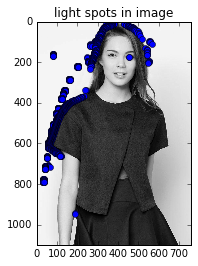

In [9]:
plt.plot(light_spots[:, 1], light_spots[:, 0], 'o')
plt.imshow(img)
plt.title('light spots in image')

We do the same for the dark spots in the image:

In [10]:
dark_spots = np.array((img < 3).nonzero()).T

In [11]:
dark_spots.shape

(1402, 2)

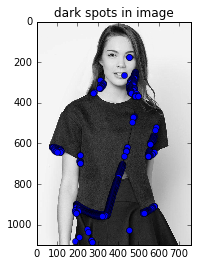

In [12]:
plt.plot(dark_spots[:, 1], dark_spots[:, 0], 'o')
plt.imshow(img)
plt.title('dark spots in image')

# Making a seed mask

Using the previous points, we can use the labelling function from `scipy.ndimage` to make a seed mask:

In [13]:
from scipy import ndimage as ndi
bool_mask = np.zeros(img.shape, dtype=np.bool)
bool_mask[tuple(light_spots.T)] = True
bool_mask[tuple(dark_spots.T)] = True
seed_mask, num_seeds = ndi.label(bool_mask)
num_seeds

672

We have 672 labels in our seed mask. Let's now perform the watershed.

# Applying the watershed 

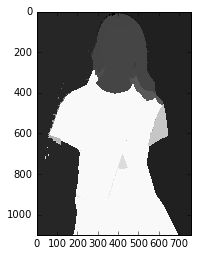

In [14]:
from skimage import morphology
ws = morphology.watershed(blurred, seed_mask)
plt.imshow(ws)

This looks pretty nice. However, we have several classes here. Ideally, we want to remove the background, which would be the class with the most pixels in the image. Let's do that.

In [15]:
background = max(set(ws.ravel()), key=lambda g: np.sum(ws == g))
background

656

Let's make a mask that removes that class:

In [16]:
background_mask = (ws == background)

Now, let's look at the result:

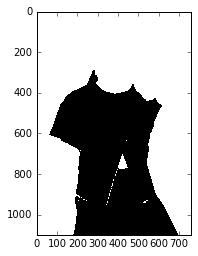

In [17]:
plt.imshow(~background_mask)

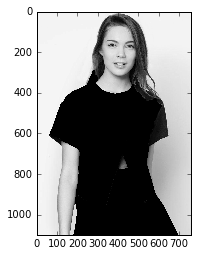

In [18]:
cleaned = img * ~background_mask
plt.imshow(cleaned)

Is this good or not? Let's apply a red color to the background to check:

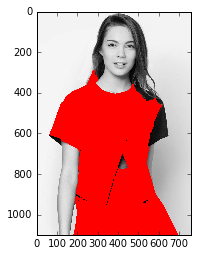

In [19]:
plt.imshow(cleaned, cmap='gray')
plt.imshow(background_mask.reshape(background_mask.shape + (1,)) * np.array([1, 0, 0, 1]))

Not exactly what we were looking for! Can we do better? What about selecting another group for the background mask?

# Picking another group 

Actually, now that we have the previous code, we can do a loop over the different groups for background candidates. First, let's reuse our previous processing steps as a function:

In [20]:
def draw_group_as_background(ax, group, watershed_result, original_image):
    "Draws a group from the watershed result as red background."
    background_mask = (watershed_result == group)
    cleaned = original_image * ~background_mask
    ax.imshow(cleaned, cmap='gray')
    ax.imshow(background_mask.reshape(background_mask.shape + (1,)) * np.array([1, 0, 0, 1]))

In [21]:
background_candidates = sorted(set(ws.ravel()), key=lambda g: np.sum(ws == g), reverse=True)

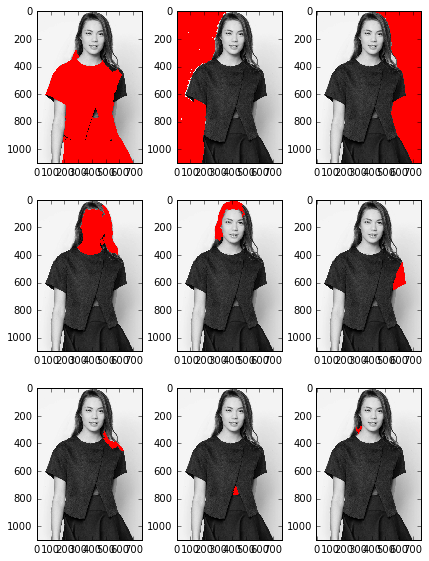

In [22]:
N = 3
fig, axes = plt.subplots(N, N, figsize=(6, 8))
for i in range(N*N):
    draw_group_as_background(axes.ravel()[i], background_candidates[i], ws, img)
plt.tight_layout()

Mmmh, that's not exactly what we expected: the background is split in two images. Can we do better? One way I can think of is using better seeds for the back and foreground. Let's try this!

# Manually inputting seeds 

Now that I think of it, there's actually only two seeds that we need: one for the background, one for the foreground. Let's select these two manually.

In [23]:
seed_mask = np.zeros(img.shape, dtype=np.int)
seed_mask[0, 0] = 1 # background
seed_mask[600, 400] = 2 # foreground

Let's perform the watershed again.

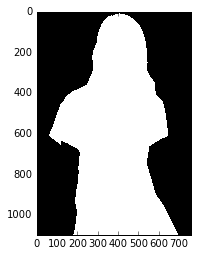

In [24]:
ws = morphology.watershed(blurred, seed_mask)
plt.imshow(ws)

That's better!

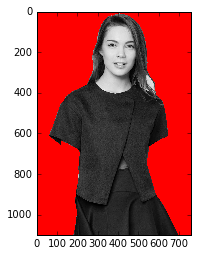

In [25]:
fig, ax = plt.subplots()
draw_group_as_background(ax, 1, ws, img)

However, we're still missing an arm. How can we recover it? Let's try and just add an extra seed to the arm!

In [26]:
seed_mask = np.zeros(img.shape, dtype=np.int)
seed_mask[0, 0] = 1 # background
seed_mask[600, 400] = 2 # foreground
seed_mask[1000, 150] = 2 # left arm

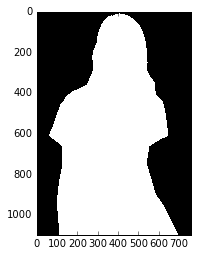

In [27]:
ws = morphology.watershed(blurred, seed_mask)
plt.imshow(ws)

Time to compare the original image and our result!

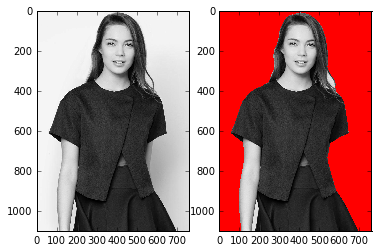

In [28]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(img)
draw_group_as_background(ax[1], 1, ws, img)

We have obtained almost the same contour as the one shown in the source on stackoverflow, with minimal effort.

# Conclusions 

This notebook has showcased that it is relatively easy to design background removal algorithms using scikit-image. The approach we have used here is quite robust except for the fact that we manually specified which points we wanted to keep in the final image. Even though we haven't investigated this, it could be that the other approach (seeds taken from distance map after segmenting the edge image) is more efficient. In any case, it was quite fun to do this little study.